# Image Retrieval with Azure Computer Vision 4.0

## Import libraries

In [1]:
import os
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
import glob
import json
import pathlib
from azurecv import (image_embedding, text_embedding, get_cosine_similarity, 
                     get_image_embedding_multiprocessing, 
                     search_by_image, search_by_text)

## Load Azure Computer Vision Endpoint & Key

In [2]:
# Load environment variables
load_dotenv()
endpoint = os.getenv('CV_ENDPOINT') + "computervision/"
key = os.getenv('CV_KEY')

## Image and text embeddings

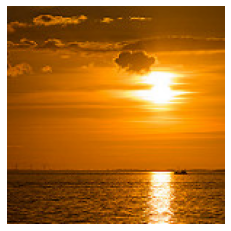

In [3]:
# image embedding
image = "images/image (18).jpg"
image_emb = image_embedding(image, endpoint, key)

# display the image
plt.imshow(Image.open(image))
plt.axis('off')
plt.show()

### Text-based image retrieval

In [4]:
txt = "sunset in the sea"
txt_emb = text_embedding(txt, endpoint, key)

In [5]:
cos_similarity = get_cosine_similarity(image_emb, txt_emb)
print(f"Cosine similarity: {cos_similarity}")

Cosine similarity: 0.3225007550881353


In [6]:
txt = "mountain peaks"
txt_emb = text_embedding(txt, endpoint, key)

In [7]:
cos_similarity = get_cosine_similarity(image_emb, txt_emb)
print(f"Cosine similarity: {cos_similarity}")

Cosine similarity: 0.15754042352674827


### Image-based image retrieval

In [8]:
# image embedding
img_mountains_1 = "images/image (4).jpg"
image_emb_1 = image_embedding(img_mountains_1, endpoint, key)
img_mountains_2 = "images/image (7).jpg"
image_emb_2 = image_embedding(img_mountains_2, endpoint, key)

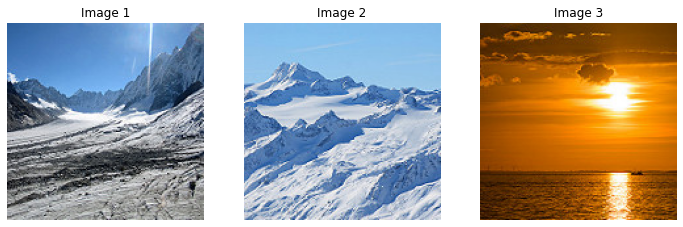

In [9]:
# display the 3 images
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
axes[0].imshow(Image.open(img_mountains_1))
axes[0].set_title("Image 1")
axes[0].axis('off')
axes[1].imshow(Image.open(img_mountains_2))
axes[1].set_title("Image 2")
axes[1].axis('off')
axes[2].imshow(Image.open(image))
axes[2].set_title("Image 3")
axes[2].axis('off')
plt.show()

In [10]:
print(f"Cosine similarity Image 1 and Image 2: {get_cosine_similarity(image_emb_1, image_emb_2)}")
print(f"Cosine similarity Image 1 and Image 3: {get_cosine_similarity(image_emb_1, image_emb)}")
print(f"Cosine similarity Image 2 and Image 3: {get_cosine_similarity(image_emb_2, image_emb)}")

Cosine similarity Image 1 and Image 2: 0.7436738639053782
Cosine similarity Image 1 and Image 3: 0.44542597784365107
Cosine similarity Image 2 and Image 3: 0.5179377503895738


## Generate embeddings for the image dataset

In [11]:
images_folder = "images"
image_files = glob.glob(images_folder + "/*")

print(f"Total number of images: {len(image_files)}")

Total number of images: 200


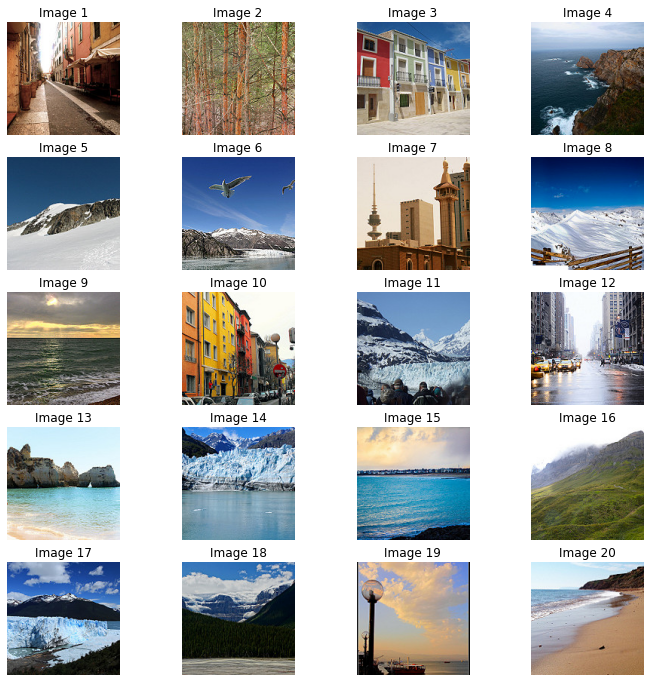

In [12]:
# display the images
nrows = 5
ncols = 4
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
for irow in range(nrows):
    for icol in range(ncols):
        axes[irow,icol].imshow(Image.open(image_files[ncols*irow + icol + 1]))
        axes[irow,icol].set_title(f"Image {ncols*irow + icol + 1}")
        axes[irow,icol].axis('off')
plt.show()

### Generate image embeddings

In [13]:
print(f"Computing vector embeddings for {len(image_files)} images.")
image_embeddings = get_image_embedding_multiprocessing(image_files, endpoint, key, max_workers=4, max_attempts=20)
print("Done!")
print(f"Number of processed files: {len(image_files)}")
print(f"Number of vector embeddings generated: {len(image_embeddings)}")

Computing vector embeddings for 200 images.


100%|██████████| 200/200 [00:21<00:00,  9.34it/s]

Done!
Number of processed files: 200
Number of vector embeddings generated: 200


### Export image embeddings to JSON file

In [14]:
output_folder = "output"
pathlib.Path(output_folder).mkdir(parents=True, exist_ok=True)

In [15]:
emb_json = os.path.join(output_folder, "embeddings.json")

# Saving vectors embeddings into the json file
with open(emb_json, "w") as json_file:
    json.dump(image_embeddings, json_file)

print(f"Vector embeddings have been saved in: {emb_json}")

Vector embeddings have been saved in: output\embeddings.json


## Search by image or text prompt

### Load embeddings and test images

In [16]:
emb_json = os.path.join(output_folder, "embeddings.json")

with open(emb_json) as f:
    image_embeddings = json.load(f)

print(f"Number of imported vector embeddings: {len(image_embeddings)}")

Number of imported vector embeddings: 200


In [17]:
test_folder = "test_images"
test_image_files = glob.glob(test_folder + "/*")

print(f"Total number of test images: {len(test_image_files)}")

Total number of test images: 6


### Test 1: Image-to-image search

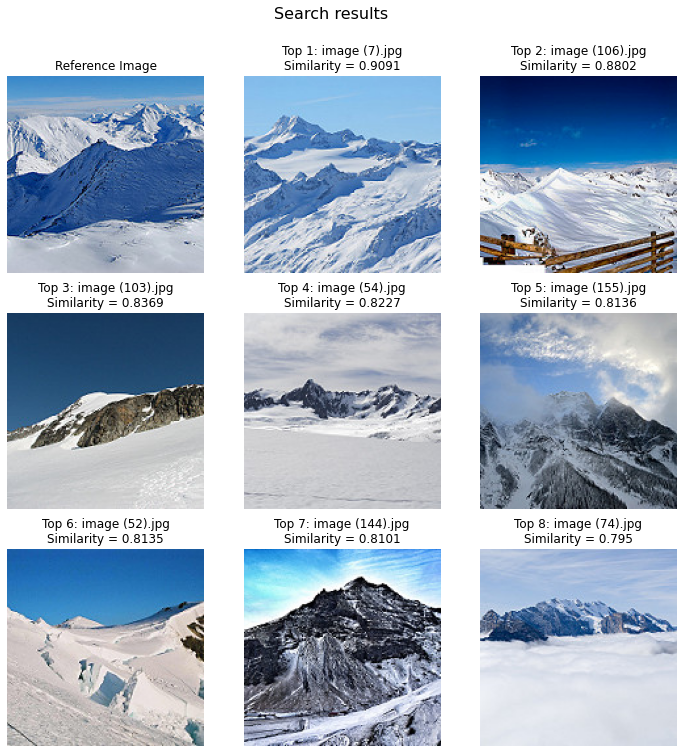

In [18]:
test_image = test_image_files[1]
df = search_by_image(test_image, image_files, image_embeddings, endpoint, key, topn=8, disp=True)

In [19]:
print("Similarity results:")
df.head(10)

Similarity results:


,image_file,similarity
167,images\image (7).jpg,0.909071
8,images\image (106).jpg,0.880209
5,images\image (103).jpg,0.836946
150,images\image (54).jpg,0.822727
62,images\image (155).jpg,0.813631
148,images\image (52).jpg,0.813482
50,images\image (144).jpg,0.810119
172,images\image (74).jpg,0.795006
156,images\image (6).jpg,0.788049
199,images\image (99).jpg,0.781270


### Test 2: Text-to-image search

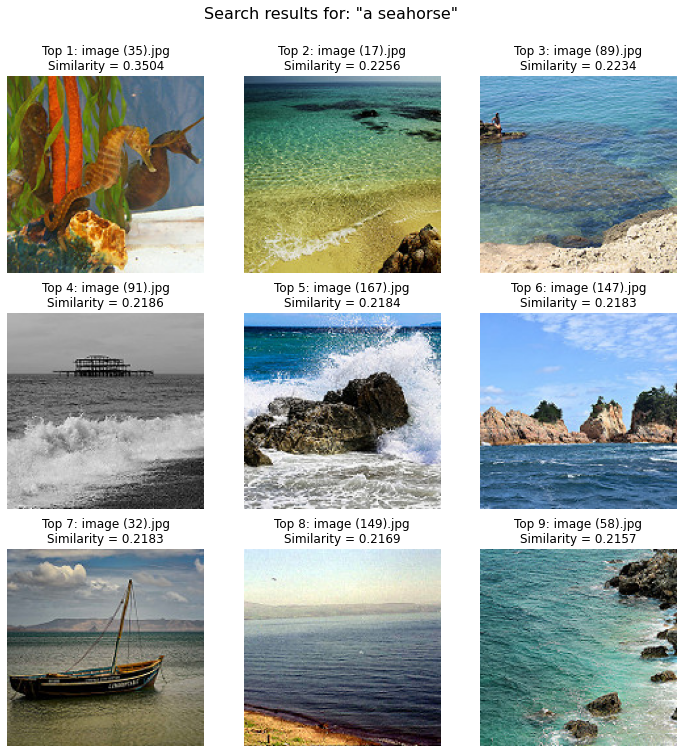

In [20]:
df_text = search_by_text('a seahorse', image_files, image_embeddings, endpoint, key, topn=9, disp=True)

In [21]:
print("Similarity results:")
df_text.head(10)

Similarity results:


,image_file,similarity
129,images\image (35).jpg,0.350393
78,images\image (17).jpg,0.225554
188,images\image (89).jpg,0.223435
191,images\image (91).jpg,0.218609
75,images\image (167).jpg,0.218425
53,images\image (147).jpg,0.218326
126,images\image (32).jpg,0.218254
55,images\image (149).jpg,0.216886
154,images\image (58).jpg,0.215702
124,images\image (30).jpg,0.215249
